In [2]:

import os
from os.path import join
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
figdir = "/Users/binxuwang/Dropbox/LastLickClosedLoop/LastLickData/XGBoostClassifier"
outdir = "/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/SabatiniShijiaLickingClassifier/Figures"
os.makedirs(outdir, exist_ok=True)
seed = 41
test_size = 0.2
plt.rcParams["axes.grid"] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
from neural_data_loading import load_data
import torch

neural_mat, lastlicksId_mat, firstboutId_mat = load_data()
# lick_mat = lastlicksId_mat
lick_mat = lastlicksId_mat & firstboutId_mat
neuron_mean = neural_mat.mean(axis=(0, 2))
neuron_std = neural_mat.std(axis=(0, 2))
# normalize
neural_tsr_zscore = ((neural_mat.astype("float32") - neural_mat.mean(axis=(0, 2), keepdims=True))
                     / neural_mat.std(axis=(0, 2), keepdims=True))
device = "cpu"
neural_tsr_zscore_th = torch.from_numpy(neural_tsr_zscore).float().to(device)
lick_mat_th = torch.from_numpy(lick_mat[0]).long().to(device)

Neural data (4728, 385, 41)
Last lick Id (1, 4728)
First bout Id (1, 4728)


## Neural Network Predictor

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn.utils import weight_norm
from torch.utils.data import TensorDataset, DataLoader

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]
        layers += [nn.AdaptiveMaxPool1d(1)]
        layers += [nn.Flatten()]
        layers += [nn.Linear(num_channels[-1], 2)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    neural_tsr_zscore_th, lick_mat_th,
    test_size=0.2, random_state=41, shuffle=True,)

In [9]:
class_freq = y_train.bincount().float()
class_weight = class_freq.sum() / class_freq
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weight)

In [10]:
def train_model(net, optimizer, batchsize, num_epochs):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    train_tpallp_ratio = []
    test_tpallp_ratio = []
    train_detect_ratio = []
    test_detect_ratio = []
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    for epoch in range(num_epochs):
        net.train()
        for Xbatch, ybatch in train_loader:
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(Xbatch)
            loss = criterion(outputs, ybatch)
            loss.backward()
            optimizer.step()
        # forward + backward + optimize
        with torch.no_grad():
            outputs = net(X_train)
        loss = criterion(outputs, y_train)
        pred = outputs.argmax(dim=1).detach().cpu()
        confmat_train = confusion_matrix(y_train.cpu(), pred)
        train_loss.append(loss.item())
        train_acc.append(accuracy_score(y_train, pred))
        train_tpallp_ratio.append(confmat_train[1, 1] / confmat_train[:, 1].sum())
        train_detect_ratio.append(confmat_train[1, 1] / confmat_train[1, :].sum())
        # evaluate on the test set
        net.eval()
        with torch.no_grad():
            outputs = net(X_test)
        loss = criterion(outputs, y_test)
        pred = outputs.argmax(dim=1).detach().cpu()
        confmat_test = confusion_matrix(y_test.cpu(), pred)
        # print statistics
        test_loss.append(loss.item())
        test_acc.append(accuracy_score(y_test, pred))
        test_tpallp_ratio.append(confmat_test[1, 1] / confmat_test[:, 1].sum())
        test_detect_ratio.append(confmat_test[1, 1] / confmat_test[1, :].sum())
        if epoch % 1 == 0:
            print(f"Epoch {epoch} | Loss: Train {train_loss[-1]:.3f} Test {test_loss[-1]:.3f} | "
                  f"Acc: Train {train_acc[-1]:.3f} Test {test_acc[-1]:.3f} | "
                  f"TP/(TP+FP): Train {train_tpallp_ratio[-1]:.3f} Test {test_tpallp_ratio[-1]:.3f} | "
                  f"TP/(TP+miss): Train {train_detect_ratio[-1]:.3f} Test {test_detect_ratio[-1]:.3f}")
    trainstats = {"train_loss": train_loss, "test_loss": test_loss,
             "train_acc": train_acc, "test_acc": test_acc,
             "train_tpallp_ratio": train_tpallp_ratio, "test_tpallp_ratio": test_tpallp_ratio,
             "train_detect_ratio": train_detect_ratio, "test_detect_ratio": test_detect_ratio}
    return net, trainstats

In [12]:
num_channel = neural_mat.shape[1]
num_hidden = 256
num_output = 2
dropout = 0.2
net = nn.Sequential(
    nn.Conv1d(num_channel, num_hidden, kernel_size=7, padding=1),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Conv1d(num_hidden, num_hidden, kernel_size=5, padding=1),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Conv1d(num_hidden, num_hidden, kernel_size=3, padding=1),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Conv1d(num_hidden, num_hidden, kernel_size=3, padding=1),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    # nn.Conv1d(num_hidden, num_hidden, kernel_size=3, padding=1),
    # nn.BatchNorm1d(num_hidden),
    # nn.ReLU(),
    # nn.Dropout(0.5),
    # pooling
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(num_hidden, num_output),
    # nn.Softmax(dim=1)
)

In [13]:
optimizer = optim.Adam(net.parameters(), lr=0.005)
net, stats = train_model(net, optimizer, batchsize=512, num_epochs=100)

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_29765/1751803852.py:42: RuntimeWarning: invalid value encountered in scalar divide
  test_tpallp_ratio.append(confmat_test[1, 1] / confmat_test[:, 1].sum())


Epoch 0 | Loss: Train 0.802 Test 29.109 | Acc: Train 0.741 Test 0.928 | TP/(TP+FP): Train 0.153 Test nan | TP/(TP+miss): Train 0.554 Test 0.000
Epoch 1 | Loss: Train 0.603 Test 1.758 | Acc: Train 0.439 Test 0.771 | TP/(TP+FP): Train 0.112 Test 0.106 | TP/(TP+miss): Train 0.957 Test 0.294
Epoch 2 | Loss: Train 0.511 Test 0.801 | Acc: Train 0.524 Test 0.698 | TP/(TP+FP): Train 0.131 Test 0.161 | TP/(TP+miss): Train 0.971 Test 0.765
Epoch 3 | Loss: Train 0.417 Test 0.760 | Acc: Train 0.792 Test 0.828 | TP/(TP+FP): Train 0.241 Test 0.238 | TP/(TP+miss): Train 0.849 Test 0.632
Epoch 4 | Loss: Train 0.294 Test 0.513 | Acc: Train 0.865 Test 0.864 | TP/(TP+FP): Train 0.344 Test 0.308 | TP/(TP+miss): Train 0.928 Test 0.721
Epoch 5 | Loss: Train 0.234 Test 0.612 | Acc: Train 0.888 Test 0.897 | TP/(TP+FP): Train 0.388 Test 0.374 | TP/(TP+miss): Train 0.921 Test 0.632
Epoch 6 | Loss: Train 0.255 Test 0.648 | Acc: Train 0.910 Test 0.825 | TP/(TP+FP): Train 0.441 Test 0.245 | TP/(TP+miss): Train 0.8

In [ ]:
num_channel = neural_mat.shape[1]
num_hidden = 128
net = TemporalConvNet(num_channel, [num_hidden] * 4, kernel_size=5, dropout=0.2)
optimizer = optim.Adam(net.parameters(), lr=0.01)
net, stats = train_model(net, optimizer, batchsize=512, num_epochs=100)

* https://youtrack.jetbrains.com/issue/PY-61385/PyCharm-Python-Console-crashes-everytime-I-use-PyTorch


/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch 0 | Loss: Train 0.531 Test 0.561 | Acc: Train 0.682 Test 0.542 | TP/(TP+FP): Train 0.168 Test 0.127 | TP/(TP+miss): Train 0.842 Test 0.912
Epoch 1 | Loss: Train 0.524 Test 0.604 | Acc: Train 0.476 Test 0.394 | TP/(TP+FP): Train 0.122 Test 0.105 | TP/(TP+miss): Train 0.993 Test 0.985
Epoch 2 | Loss: Train 0.363 Test 0.472 | Acc: Train 0.874 Test 0.818 | TP/(TP+FP): Train 0.349 Test 0.259 | TP/(TP+miss): Train 0.824 Test 0.824
Epoch 3 | Loss: Train 0.292 Test 0.439 | Acc: Train 0.831 Test 0.745 | TP/(TP+FP): Train 0.298 Test 0.201 | TP/(TP+miss): Train 0.960 Test 0.853
Epoch 4 | Loss: Train 0.257 Test 0.469 | Acc: Train 0.944 Test 0.890 | TP/(TP+FP): Train 0.581 Test 0.368 | TP/(TP+miss): Train 0.878 Test 0.735
Epoch 5 | Loss: Train 0.187 Test 0.398 | Acc: Train 0.884 Test 0.813 | TP/(TP+FP): Train 0.388 Test 0.258 | TP/(TP+miss): Train 0.996 Test 0.853
Epoch 6 | Loss: Train 0.145 Test 0.415 | Acc: Train 0.948 Test 0.888 | TP/(TP+FP): Train 0.589 Test 0.370 | TP/(TP+miss): Train 0.

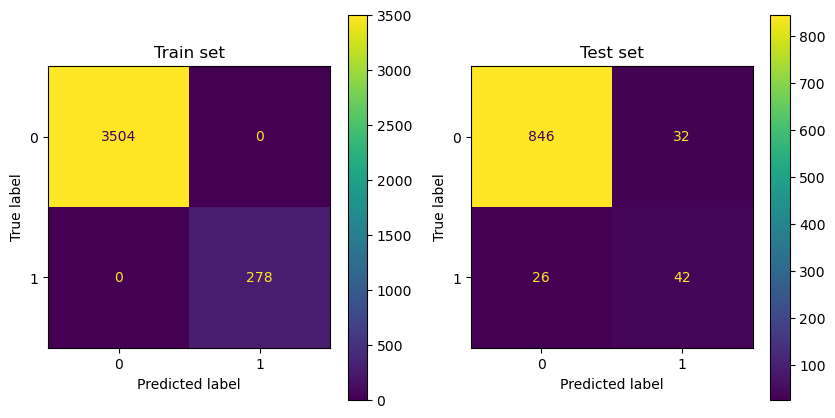

[[3504    0]
 [   0  278]]
[[846  32]
 [ 26  42]]


In [ ]:
# train the network
num_channel = neural_mat.shape[1]
num_hidden = 128
net = TemporalConvNet(num_channel, [num_hidden] * 4, kernel_size=3, dropout=0.2)
optimizer = optim.Adam(net.parameters(), lr=0.005)
batchsize = 512
num_epochs = 50
train_loss = []
test_loss = []
train_acc = []
test_acc = []
train_tpallp_ratio = []
test_tpallp_ratio = []
train_detect_ratio = []
test_detect_ratio = []
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
for epoch in range(num_epochs):
    net.train()
    for Xbatch, ybatch in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(Xbatch)
        loss = criterion(outputs, ybatch)
        loss.backward()
        optimizer.step()
    # forward + backward + optimize
    with torch.no_grad():
        outputs = net(X_train)
    loss = criterion(outputs, y_train)
    pred = outputs.argmax(dim=1).detach().cpu()
    confmat_train = confusion_matrix(y_train.cpu(), pred)
    train_loss.append(loss.item())
    train_acc.append(accuracy_score(y_train, pred))
    train_tpallp_ratio.append(confmat_train[1, 1] / confmat_train[:, 1].sum())
    train_detect_ratio.append(confmat_train[1, 1] / confmat_train[1, :].sum())
    # evaluate on the test set
    net.eval()
    with torch.no_grad():
        outputs = net(X_test)
    loss = criterion(outputs, y_test)
    pred = outputs.argmax(dim=1).detach().cpu()
    confmat_test = confusion_matrix(y_test.cpu(), pred)
    # print statistics
    test_loss.append(loss.item())
    test_acc.append(accuracy_score(y_test, pred))
    test_tpallp_ratio.append(confmat_test[1, 1] / confmat_test[:, 1].sum())
    test_detect_ratio.append(confmat_test[1, 1] / confmat_test[1, :].sum())
    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Loss: Train {train_loss[-1]:.3f} Test {test_loss[-1]:.3f} | "
              f"Acc: Train {train_acc[-1]:.3f} Test {test_acc[-1]:.3f} | "
              f"TP/(TP+FP): Train {train_tpallp_ratio[-1]:.3f} Test {test_tpallp_ratio[-1]:.3f} | "
              f"TP/(TP+miss): Train {train_detect_ratio[-1]:.3f} Test {test_detect_ratio[-1]:.3f}")

In [ ]:
# plot confusion matrix for the test set and train set
# confmat = confusion_matrix(ytest, outputs.argmax(dim=1))
train_outputs = net(X_train)
train_confmat = confusion_matrix(y_train, train_outputs.argmax(dim=1))
test_outputs = net(X_test)
test_confmat = confusion_matrix(y_test, test_outputs.argmax(dim=1))
# print the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ConfusionMatrixDisplay(train_confmat).plot(ax=ax[0])
ax[0].set_title("Train set")
ConfusionMatrixDisplay(test_confmat).plot(ax=ax[1])
ax[1].set_title("Test set")
plt.show()
print(train_confmat)
print(test_confmat)